<a href="https://colab.research.google.com/github/LeeSeungwon89/Kaggle_Dacon_Practice/blob/main/Titanic_baseline_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle
from google.colab import files
files.upload()

In [ ]:
ls -1ha kaggle.json

kaggle.json


In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# Permission Warning이 발생하지 않도록 해줍니다.
!chmod 600 ~/.kaggle/kaggle.json

# 내가 참가한 대회 리스트를 확인합니다.
!kaggle competitions list

In [ ]:
!kaggle competitions download -c titanic

  0% 0.00/34.1k [00:00<?, ?B/s]
100% 34.1k/34.1k [00:00<00:00, 23.5MB/s]


In [ ]:
!ls

kaggle.json  sample_data  titanic.zip


In [ ]:
!unzip titanic.zip

Archive:  titanic.zip
  inflating: gender_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


# **피처 엔지니어링**

In [ ]:
import numpy as np
import pandas as pd

pd.set_option('display.max_column', 50)
pd.set_option('display.max_rows', 50)

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
submission = pd.read_csv('gender_submission.csv')

# 피처 엔지니어링을 위해 훈련 및 테스트 데이터를 결합합니다.
all_data = pd.concat([train, test], ignore_index=True)
all_data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,NaN,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
1305,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
1306,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
1307,1308,NaN,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


In [ ]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


피처 요약표를 출력하겠습니다.

In [ ]:
def feature_table(df):
    # 피처 이름과 타입을 출력합니다.     
    feature_description = pd.DataFrame(df.dtypes, columns=['type'])
    feature_description = feature_description.reset_index()
    feature_description = feature_description.rename(columns={'index': 'feature'})
    # 결측치 개수를 산출합니다.
    feature_description['null count'] = df.isnull().sum().values
    # 고윳값 개수를 산출합니다.
    feature_description['eigenvalue count'] = df.nunique().values
    
    # 데이터 크기를 출력합니다.    
    print(df.shape)
    
    return feature_description

In [ ]:
feature_table(all_data)

(1309, 12)


,feature,type,null count,eigenvalue count
0,PassengerId,int64,0,1309
1,Survived,float64,418,2
2,Pclass,int64,0,3
3,Name,object,0,1307
4,Sex,object,0,2
5,Age,float64,263,98
6,SibSp,int64,0,7
7,Parch,int64,0,8
8,Ticket,object,0,929
9,Fare,float64,1,281


먼저 결측치부터 처리하겠습니다. 결측치가 존재하는 피처는 타깃값을 제외한 'Age', 'Fare', 'Cabin', 'Embarked'입니다. EDA에서 'Cabin' 피처는 사용하기 부적절하여 제거하는 편이 낫다는 판단을 내렸습니다. 먼저 'Cabin' 피처부터 제거하겠습니다.

In [ ]:
all_data = all_data.drop('Cabin', axis=1)
all_data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S
...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,NaN,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,S
1305,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C
1306,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,S
1307,1308,NaN,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,S


'Age' 피처의 결측치를 처리하겠습니다. 먼저 'Age' 피처의 값 분포를 확인하겠습니다.

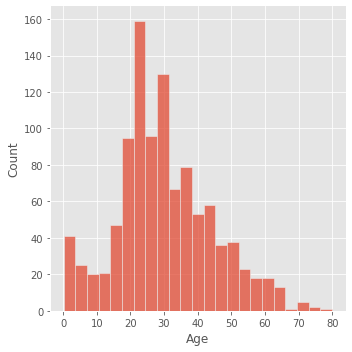

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

mpl.rc('font', size=20)
plt.style.use('ggplot')

sns.displot(x='Age', data=all_data)

평균값으로 채워 보겠습니다. 전체 나이를 평균하여 채우거나 다른 피처와 그룹화하여 산출한 평균으로 채우는 방법이 있습니다. EDA에서 확인하였듯이 'Pclass' 피처(티켓 등급)별로 연령대가 다르다는 점을 확인했습니다. 특히 나이가 많을수록 티켓 등급이 높아지는 경향을 보였습니다. 따라서 'Pclass' 피처별 'Age' 피처의 평균으로 결측치를 채워 보겠습니다. 'Pclass' 피처별 'Age' 피처의 평균을 담은 데이터프레임을 만들겠습니다.

In [ ]:
pclass_age_mean = all_data[['Pclass', 'Age']].groupby('Pclass').mean().reset_index()
pclass_age_mean.columns = ['Pclass', 'Age_mean']
pclass_age_mean

,Pclass,Age_mean
0,1,39.159930
1,2,29.506705
2,3,24.816367


이 데이터프레임을 원본 데이터에 병합하겠습니다.

In [ ]:
all_data = pd.merge(all_data, pclass_age_mean, on='Pclass', how='left')
all_data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Age_mean
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,24.816367
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,39.159930
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,24.816367
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,39.159930
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,24.816367
...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,NaN,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,S,24.816367
1305,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C,39.159930
1306,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,S,24.816367
1307,1308,NaN,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,S,24.816367


병합된 평균 피처를 결측치에 채우고 삭제하겠습니다.

In [ ]:
all_data.loc[all_data['Age'].isnull(), 'Age'] = all_data['Age_mean']
all_data = all_data.drop('Age_mean', axis=1)
all_data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.000000,1,0,A/5 21171,7.2500,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000000,1,0,PC 17599,71.2833,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.000000,0,0,STON/O2. 3101282,7.9250,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000000,1,0,113803,53.1000,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.000000,0,0,373450,8.0500,S
...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,NaN,3,"Spector, Mr. Woolf",male,24.816367,0,0,A.5. 3236,8.0500,S
1305,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.000000,0,0,PC 17758,108.9000,C
1306,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.500000,0,0,SOTON/O.Q. 3101262,7.2500,S
1307,1308,NaN,3,"Ware, Mr. Frederick",male,24.816367,0,0,359309,8.0500,S


나이 분포를 확인하겠습니다.

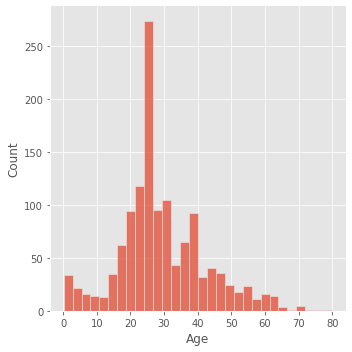

In [ ]:
sns.displot(x='Age', data=all_data)

'Fare' 피처의 결측치를 처리하겠습니다. 'Fare' 피처는 결측치가 1개이므로 평균값으로 채울 예정입니다. 단, 'Pclass' 피처와 'Fare' 피처간 상관관계가 크므로 전체 'Fare' 피처의 평균값이 아닌 'Pclass' 피처별 'Fare' 피처의 평균값을 채우는 편이 옳다고 판단합니다. 결측치를 채우는 방법은 위에서 평균 나이를 채우는 방법과 같습니다.

In [ ]:
pclass_fare_mean = all_data[['Pclass', 'Fare']].groupby('Pclass').mean().reset_index()
pclass_fare_mean.columns = ['Pclass', 'Fare_mean']
pclass_fare_mean

,Pclass,Fare_mean
0,1,87.508992
1,2,21.179196
2,3,13.302889


In [ ]:
all_data = pd.merge(all_data, pclass_fare_mean, on='Pclass', how='left')
all_data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Fare_mean
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.000000,1,0,A/5 21171,7.2500,S,13.302889
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000000,1,0,PC 17599,71.2833,C,87.508992
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.000000,0,0,STON/O2. 3101282,7.9250,S,13.302889
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000000,1,0,113803,53.1000,S,87.508992
4,5,0.0,3,"Allen, Mr. William Henry",male,35.000000,0,0,373450,8.0500,S,13.302889
...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,NaN,3,"Spector, Mr. Woolf",male,24.816367,0,0,A.5. 3236,8.0500,S,13.302889
1305,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.000000,0,0,PC 17758,108.9000,C,87.508992
1306,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.500000,0,0,SOTON/O.Q. 3101262,7.2500,S,13.302889
1307,1308,NaN,3,"Ware, Mr. Frederick",male,24.816367,0,0,359309,8.0500,S,13.302889


In [ ]:
all_data.loc[all_data['Fare'].isnull(), 'Fare'] = all_data['Fare_mean']
all_data = all_data.drop('Fare_mean', axis=1)
all_data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.000000,1,0,A/5 21171,7.2500,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000000,1,0,PC 17599,71.2833,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.000000,0,0,STON/O2. 3101282,7.9250,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000000,1,0,113803,53.1000,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.000000,0,0,373450,8.0500,S
...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,NaN,3,"Spector, Mr. Woolf",male,24.816367,0,0,A.5. 3236,8.0500,S
1305,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.000000,0,0,PC 17758,108.9000,C
1306,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.500000,0,0,SOTON/O.Q. 3101262,7.2500,S
1307,1308,NaN,3,"Ware, Mr. Frederick",male,24.816367,0,0,359309,8.0500,S


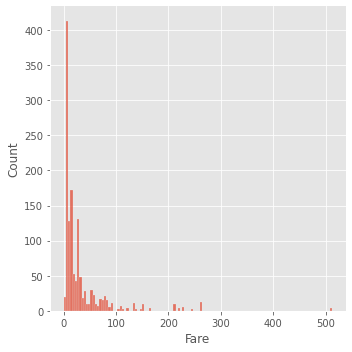

In [20]:
sns.displot(x='Fare', data=all_data)

마지막으로 'Embarked' 피처는 명목형 피처이므로 최빈값으로 대체해 보겠습니다.

In [42]:
all_data.loc[all_data['Embarked'].isnull(), 'Embarked'] = all_data['Embarked'].value_counts().max()



---

진행 중

---

